# Computer Vision and Deep Learning - Laboratory 4
 
The main objective of this laboratory is to familiarize you with the training process of a neural network. More specifically, you'll follow this ["recipe"](!http://karpathy.github.io/2019/04/25/recipe/) for training  neural networks proposed by Andrew Karpathy.
You'll go through all the steps of training, data preparation, debugging, hyper-parameter tuning.
 
In the second part of the laboratory, you'll experiment with _transfer learning_ and _fine-tuning_.  Transfer learning is a concept from machine learning which allows you to reuse the knowledge gained while solving a problem (in our case the CNN weights) and applying it to solve a similar problem. This is useful when you are facing a classification problem with a small training dataset.


In [14]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2.cv2 as cv2
import glob
from PIL import Image


color = 'red'
plt.rcParams['text.color'] = color
plt.rcParams['axes.labelcolor'] = color
plt.rcParams['xtick.color'] = color
plt.rcParams['ytick.color'] = color
print("done")

done


# Data loading. Training a neural network. Tuning hyper-parameters. 

Your task for the first part of the laboratory is to train a convolutional nerual network for image classification. You can choose any dataset for image classification. By default you can use the [Oxford Pets dataset](!https://www.robots.ox.ac.uk/~vgg/data/pets/), but you can choose a dataset that you will be using for your project or an interesting dataset from [Kaggle](!https://www.kaggle.com/datasets?search=image).

So the first step would be download your training data.

In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz # replace it with the link to the dataset that you will be using
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz 

!tar -xvf images.tar.gz
!tar -xvf annotations.tar.gz 

## Data loading 
 
Up until now, we could load the data to train our model in a single line of code: we just used numpy.load to read the entire training and test sets into memory.
However, in some cases we won't be able to fit all the data into the memory due to hardware constraints.
 
To alleviate this problem, we'll use the [_Sequence_](!https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence) class from tensorflow which allows us to feed data to our models.
To write a custom data generator, you'll have to 
- write a class that inherits from the class _Sequence_
- override the \_\_len\_\_ method: this method should return the number of batches in a sequence. In this method you can just return the value:
\begin{equation}
len = \frac{training\_samples}{batch\_size}
\end{equation}
- override the \_\_get_item\_\_(self, index) method: this should return a complete batch;
- optionally, you can override other methods, such as on_epoch_end(). For example, here you could shuffle the data after each epoch.
 
What's nice about this is that when calling the fit() method on a model with a _Sequence_, you can set the use_multiprocessing to True and use several workers that will generate the training batches in parallel.
 
``
fit(
    x=None, y=None, batch_size=None, epochs=1, verbose='auto',
    callbacks=None, validation_split=0.0, validation_data=None, shuffle=True,
    class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None,
    validation_steps=None, validation_batch_size=None, validation_freq=1,
    max_queue_size=10, workers=1, use_multiprocessing=False
)
``
 
Start by writing a custom data generator for the dataset that you chose.

In [2]:
import threading
def run_task(items, target, args):
    """
    Splits items in several batches and runs target with args on each batch in parallel
    (on same number of threads as cpu cores)
    """
    chunk = len(items) // os.cpu_count()
    threads = []
    for startIndex in range(0, os.cpu_count()):
        if startIndex == os.cpu_count() - 1:
            filesToProcess = items[startIndex * chunk:]
        else:
            filesToProcess = items[startIndex * chunk: (startIndex + 1) * chunk]
        thread = threading.Thread(target=target, args=[filesToProcess] + args)
        threads.append(thread)
        thread.start()
    for t in threads:
        t.join()


In [242]:
def square_image(image):
    width_pad = 0
    height_pad = 0
    if image.shape[0] > image.shape[1]:
        width_pad = (image.shape[0] - image.shape[1])//2
    else:
        height_pad = (image.shape[1] - image.shape[0])//2
    return np.pad(image, ((height_pad, height_pad), (width_pad, width_pad), (0, 0)), mode="edge")

def resize_image(path, shape):
    image = cv2.imread(path)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = square_image(image)
    return cv2.resize(image, shape)

def worker(images, shape):
    for fileName in images:
        if fileName.split(".")[-1] == "mat":
            continue
        img = resize_image(f"images/{fileName}", shape)
        cv2.imwrite(f"128_128/processed_images/{fileName}", img)

images = os.listdir("images")
#run_task(images, worker, [(128, 128)])
#worker(images)
print("done")



done


In [336]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, db_dir, batch_size, input_shape, num_classes,
                 shuffle=True):
        # TODO your initialization
        # you might want to store the parameters into class variables
        self.input_shape = input_shape
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        # load the data from the root directory
        self.class_names = []
        self.data, self.labels = self.get_data(db_dir)
        self.indices = np.arange(len(self.data))
        np.random.shuffle(self.indices)
        self.on_epoch_end()

    def get_data(self, root_dir):
        """"
        Loads the paths to the images and their corresponding labels from the database directory
        """
        # TODO your code here
        paths = glob.glob(root_dir + "/*.jpg")[:10*64]
        labels = ["_".join(os.path.basename(path).split("_")[:-1]) for path in paths]
        self.class_names = list(set(labels))
        sorted(self.class_names)

        self.data = paths
        self.labels = np.array([self.class_names.index(label) for label in labels])
        return self.data, self.labels

    def __len__(self):
        """
        Returns the number of batches per epoch: the total size of the dataset divided by the batch size
        """
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        """"
        Generates a batch of data
        """
        batch_indices = self.indices[index*self.batch_size : (index+1)*self.batch_size]
        batch_x = [] # TODO load the image from batch_indices
        for i in batch_indices:
            image = cv2.imread(self.data[i])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            batch_x.append(image)
        batch_y = self.labels[batch_indices] # TODO load the corresponding labels of the images you loaded
        # optionally you can use: batch_y = tf.keras.utils.to_categorical(batch_y, num_classes=self.num_classes)
        return (np.asarray(batch_x)-112.6)/69.7, np.asarray(batch_y)
        #return np.asarray(batch_x), np.asarray(batch_y)
        #return np.asarray(batch_x)/255.0, np.asarray(batch_y)

    def on_epoch_end(self):
        """"
        Called at the end of each epoch
        """
        # if required, shuffle your data after each epoch
        self.indices = np.arange(len(self.data))
        if self.shuffle:
            # TODO shuffle data
            # you might find np.random.shuffle useful here
            np.random.shuffle(self.indices)


Now let's look at some images and samples from our data generator.

In [255]:
generator = DataGenerator("./128_128/processed_images", 32, (64, 64, 3), 37)
all = []
for i in range(len(generator)):
    batch_x, batch_y = generator[i]
    all.append(batch_x)
all = np.concatenate(all)
print(all.shape)
print(np.mean(all), np.std(all))
print("done")


(7390, 128, 128, 3)
112.60166810981637 69.73284506233104
done


114.04502614339192 73.86399425944768


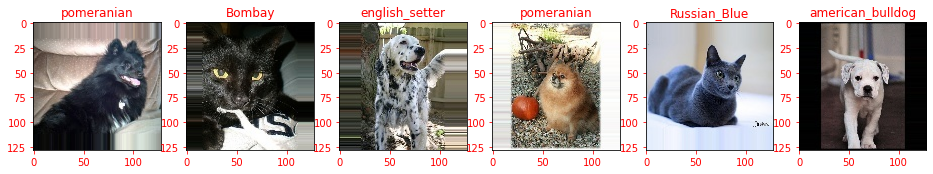

In [304]:
train_generator = DataGenerator("./128_128/train", 32, (64, 64, 3), 37)
label_names = train_generator.class_names
batch_x, batch_y = train_generator[0]
print(np.mean(batch_x), np.std(batch_x))

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=[16, 9])
for i in range(len(axes)):
    axes[i].set_title(label_names[batch_y[i]])
    axes[i].imshow(batch_x[i])

plt.show()

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)


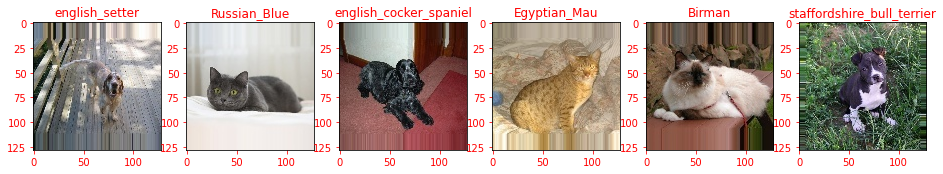

In [307]:
validation_generator = DataGenerator("./128_128/validation", 32, (64, 64, 3), 37)
label_names = validation_generator.class_names
batch_x, batch_y = validation_generator[0]

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=[16, 9])
for i in range(len(axes)):
    axes[i].set_title(label_names[batch_y[i]])
    axes[i].imshow(batch_x[i])
    print(batch_x[i].shape)
plt.show()

In [247]:
#split into train and validation

def classes_for_dir(dir):
    fileNames = os.listdir(dir)
    classesImages = {label:[] for label in label_names}

    for fileName in fileNames:
        label = "_".join(os.path.basename(fileName).split("_")[:-1])
        classesImages[label].append(fileName)
    return classesImages

check = 0
for label, images in classes_for_dir(dir = "128_128/processed_images").items():
    check += len(images)
    print(f"{label} -> {len(images)}")
print(check)


Birman -> 200
Bengal -> 200
shiba_inu -> 200
Persian -> 200
Siamese -> 200
samoyed -> 200
wheaten_terrier -> 200
boxer -> 200
english_cocker_spaniel -> 200
havanese -> 200
beagle -> 200
keeshond -> 200
american_bulldog -> 200
yorkshire_terrier -> 200
Egyptian_Mau -> 200
saint_bernard -> 200
staffordshire_bull_terrier -> 191
Abyssinian -> 200
miniature_pinscher -> 200
pug -> 200
Ragdoll -> 200
english_setter -> 200
german_shorthaired -> 200
japanese_chin -> 200
Maine_Coon -> 200
Bombay -> 200
newfoundland -> 200
Russian_Blue -> 200
leonberger -> 200
pomeranian -> 200
great_pyrenees -> 200
British_Shorthair -> 200
scottish_terrier -> 199
american_pit_bull_terrier -> 200
basset_hound -> 200
Sphynx -> 200
chihuahua -> 200
7390


In [243]:
def split_worker(items, dir, split):
    for label, images in items:
        for fileName in images:
            img = cv2.imread(f"{dir}/{fileName}")
            if np.random.rand() < split:
                cv2.imwrite(f"128_128/validation/{fileName}", img)
            else:
                cv2.imwrite(f"128_128/train/{fileName}", img)

items = list(classes_for_dir("128_128/processed_images").items())
run_task(items, split_worker, ["128_128/processed_images/", 0.1])
print("done")

done


In [245]:
train_classes = classes_for_dir("128_128/train")
validation_classes = classes_for_dir("128_128/validation")

info = classesImages = {label:[] for label in label_names}

for label, images in train_classes.items():
    info[label].append(len(images))

for label, images in validation_classes.items():
    info[label].append(len(images))

check = 0
for label, lengths in info.items():
    check += sum(lengths)
    print(f"{label} -> Train: {lengths[0]}, Val: {lengths[1]}")
print(check)
print(f"Train images: {sum([len(l) for l in train_classes.values()])}")
print(f"Validation images:  {sum([len(l) for l in validation_classes.values()])}")


Birman -> Train: 173, Val: 27
Bengal -> Train: 178, Val: 22
shiba_inu -> Train: 187, Val: 13
Persian -> Train: 174, Val: 26
Siamese -> Train: 183, Val: 17
samoyed -> Train: 181, Val: 19
wheaten_terrier -> Train: 181, Val: 19
boxer -> Train: 185, Val: 15
english_cocker_spaniel -> Train: 182, Val: 18
havanese -> Train: 177, Val: 23
beagle -> Train: 179, Val: 21
keeshond -> Train: 175, Val: 25
american_bulldog -> Train: 175, Val: 25
yorkshire_terrier -> Train: 182, Val: 18
Egyptian_Mau -> Train: 180, Val: 20
saint_bernard -> Train: 184, Val: 16
staffordshire_bull_terrier -> Train: 174, Val: 17
Abyssinian -> Train: 187, Val: 13
miniature_pinscher -> Train: 180, Val: 20
pug -> Train: 179, Val: 21
Ragdoll -> Train: 179, Val: 21
english_setter -> Train: 184, Val: 16
german_shorthaired -> Train: 180, Val: 20
japanese_chin -> Train: 185, Val: 15
Maine_Coon -> Train: 180, Val: 20
Bombay -> Train: 184, Val: 16
newfoundland -> Train: 181, Val: 19
Russian_Blue -> Train: 187, Val: 13
leonberger -> T

# CNN architecture

Write a simple tensorflow architecture for a convolutional neural network.
Use the [functional](!https://www.tensorflow.org/guide/keras/functional) api when writing the model.


In [357]:
from tensorflow.keras.layers import Conv2D, Dense, Add, Input, GlobalAvgPool2D, Flatten
from tensorflow.keras.models import Model
import tensorflow.keras as K

def resnet_block(input, filter_size=3, no_filters=16, initializer = None):
    layer1 = Conv2D(kernel_size=filter_size, filters=no_filters, padding="same", activation="relu", kernel_initializer=initializer)(input)
    layer2 = Conv2D(kernel_size=filter_size, filters=no_filters, padding="same", activation="relu", kernel_initializer=initializer)(layer1)
    return Add()([input, layer2])

def resize_block(input, filter_size=3, no_filters=16, initializer = None):
    layer1 = Conv2D(kernel_size=filter_size, filters=no_filters, strides=2, activation="relu", kernel_initializer=initializer)(input)
    layer2 = Conv2D(kernel_size=filter_size, filters=no_filters, padding="same", activation="relu", kernel_initializer=initializer)(layer1)
    resizedInput = Conv2D(kernel_size=3, filters=no_filters, strides=2, activation="relu", kernel_initializer=initializer)(input)
    return Add()([resizedInput, layer2])

def build_mini_resnet(input_size, num_classes):
    initializer = None#K.initializers.HeNormal()
    inputs = Input(shape=input_size)

    x = Conv2D(kernel_size=7, filters=32, strides=2, activation="relu", kernel_initializer=initializer)(inputs)
    x = K.layers.AvgPool2D(strides=2)(x)
    x = resnet_block(x, no_filters=32)
    x = resnet_block(x, no_filters=32)
    x = resnet_block(x, no_filters=32)

    x = resize_block(x, no_filters=64)
    x = resnet_block(x, no_filters=64)
    x = resnet_block(x, no_filters=64)
    x = resnet_block(x, no_filters=64)

    x = resize_block(x, no_filters=128)
    x = resnet_block(x, no_filters=128)
    x = resnet_block(x, no_filters=128)
    x = resnet_block(x, no_filters=128)
    x = resnet_block(x, no_filters=128)
    x = resnet_block(x, no_filters=128)

    x = resize_block(x, no_filters=256)
    x = resnet_block(x, no_filters=256)
    x = resnet_block(x, no_filters=256)
    x = GlobalAvgPool2D()(x)

    """
    x = Conv2D(kernel_size=3, filters=32, strides=2, activation="relu", kernel_initializer=initializer)(inputs)
    x = Conv2D(kernel_size=3, filters=32, activation="relu", kernel_initializer=initializer)(x)

    x = Conv2D(kernel_size=3, filters=64, strides=2, activation="relu", kernel_initializer=initializer)(x)
    x = Conv2D(kernel_size=3, filters=64, activation="relu", kernel_initializer=initializer)(x)

    x = Conv2D(kernel_size=3, filters=128, strides=2, activation="relu", kernel_initializer=initializer)(x)
    x = Conv2D(kernel_size=3, filters=128, activation="relu", kernel_initializer=initializer)(x)
    x = Conv2D(kernel_size=3, filters=128, activation="relu", kernel_initializer=initializer)(x)

    x = GlobalAvgPool2D()(x)
    #x = Flatten()(x)
    """
    # x = Dense(64, activation="relu", kernel_initializer=initializer)(x)
    # x = Dense(64, activation="relu", kernel_initializer=initializer)(x)
    x = Dense(num_classes, activation="relu", kernel_initializer=initializer)(x)
    return Model(inputs=inputs, outputs=x, name="mini_resnet")


model = build_mini_resnet((128, 128, 3), 37)
model.summary()

Model: "mini_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_182 (InputLayer)          [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_2037 (Conv2D)            (None, 61, 61, 32)   4736        input_182[0][0]                  
__________________________________________________________________________________________________
average_pooling2d_27 (AveragePo (None, 30, 30, 32)   0           conv2d_2037[0][0]                
__________________________________________________________________________________________________
conv2d_2038 (Conv2D)            (None, 30, 30, 32)   9248        average_pooling2d_27[0][0]       
________________________________________________________________________________________

## Training and fine-tuning

Start by reading this blog [post](!http://karpathy.github.io/2019/04/25/recipe/), such that you can get an idea of the pipeline that you'll have to follow when training a model.

- Triple check that your data loading is correct. (Analyse your data.)
- Check that the setup is correct.
- Overfit a simple network.
- Add regularizations.
  - data augmentation
  - weight decay

Finetune the learning rate. Use learning rate decay; here in the [documentation](!https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/LearningRateSchedule) you have an example on how you can use a learning rate scheduler in tensorflow.

You should have at least 7 different trainings. Plot all the training history.

__Save all your models and their training history!__ 


Create a google spreadsheet or a markdown table in this notebook, and report the configuration and the accuracy for all these trains. 

### Other useful videos (bias and variance, basic recipe for training a deep NN)
- https://www.youtube.com/watch?v=NUmbgp1h64E 
- https://www.youtube.com/watch?v=SjQyLhQIXSM&list=PLkDaE6sCZn6Hn0vK8co82zjQtt3T2Nkqc&index=2 
- https://www.youtube.com/watch?v=C1N_PDHuJ6Q&list=PLkDaE6sCZn6Hn0vK8co82zjQtt3T2Nkqc&index=3 




In [24]:
def plot_history(history):
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='upper right')

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    #plt.ylim([0, 1])
    plt.legend(loc='upper right')

In [358]:
# TODO your trains here


def train(epochs=40, batch_size=64, input_shape=(128, 128, 3)):
    print(f"Epochs: {epochs}\nBatch size: {batch_size}")
    lr_schedule = K.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=3e-4,
        decay_steps=epochs,
        decay_rate=0.9)

    train_generator = DataGenerator("./128_128/train", batch_size, input_shape, 37)
    print(np.mean(train_generator[0][0]), np.std(train_generator[0][0]))
    print(np.min(train_generator[0][0]), np.max(train_generator[0][0]))
    validation_generator = DataGenerator("./128_128/validation", batch_size, input_shape, 37, shuffle=False)
    print(len(train_generator), len(validation_generator))
    label_names = train_generator.class_names

    model = build_mini_resnet(input_shape, 37)
    model.summary()
    model.compile(optimizer=K.optimizers.Adam(learning_rate=lr_schedule),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'],
                 )
    
    history = model.fit(x=train_generator, epochs=epochs, batch_size=batch_size,
                         validation_data=validation_generator,
                        workers=os.cpu_count()
                         )

    plot_history(history)

Epochs: 5
Batch size: 64
0.03117125414023282 0.9790195294656373
-1.6154949784791963 2.043041606886657
1 1
Model: "mini_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_169 (InputLayer)          [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1639 (Conv2D)            (None, 61, 61, 32)   4736        input_169[0][0]                  
__________________________________________________________________________________________________
average_pooling2d_14 (AveragePo (None, 30, 30, 32)   0           conv2d_1639[0][0]                
__________________________________________________________________________________________________
conv2d_1640 (Conv2D)            (None, 30, 30, 32)   9248        average_pooling2

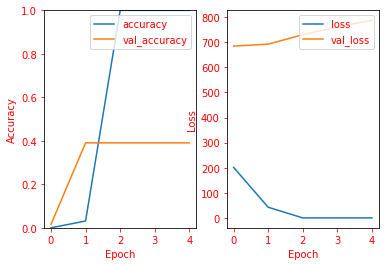

In [335]:
train(epochs=5) # overfit one batch

Epochs: 50
Batch size: 64
-0.057106591821685954 1.002947413480384
-1.6154949784791963 2.043041606886657
10 10
Model: "mini_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_184 (InputLayer)          [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_2109 (Conv2D)            (None, 61, 61, 32)   4736        input_184[0][0]                  
__________________________________________________________________________________________________
average_pooling2d_29 (AveragePo (None, 30, 30, 32)   0           conv2d_2109[0][0]                
__________________________________________________________________________________________________
conv2d_2110 (Conv2D)            (None, 30, 30, 32)   9248        average_pool

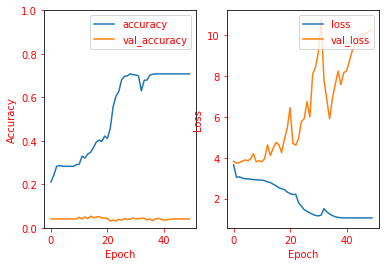

In [360]:
train(epochs=50) # overfit 10 batches

### **Extra credit**

Implement the learning rate scheduler described in the [paper](!https://arxiv.org/pdf/1608.03983.pdf) "SGDR: Stochastic gradient descent with warm restarts". You are mostly interested in Section 3 from the paper.

In [ ]:
# TODO optional extra credit assignment

## Ensembles
 
Pick your N (3 or 5) of the networks that you've trained and create an ensemble. The prediction of the ensemble is just the average of the predictions of the N networks.
 
Evaluate the ensemble (your accuracy should boost by at least 1.5%).


In [ ]:
# TODO your code here
# feed the images to the three networks, average the logits of the networks and 

# evaluate the ensemble

# Transfer learning and fine-tuning
 
In the _tensorflow.keras.applications_ module you can find implementations of several well known CNN architectures (most of the models that we covered during the lecture), as well as the pretrained weights of these models on the ImageNet dataset. 
You can use this module to apply transfer learning and fine-tuning for your classification problem. [Here](!https://keras.io/api/applications/) you can find a comprehensive table with the size of the models, number of parameters, top-1 and top-5 accuracy on the ImageNet dataset.
 
When using deep neural networks, transfer learning is the norm, not the exception.  Transfer learning refers to the situation where what has been learned in one setting is used to improve generalization in another setting.
The transfer learning pipeline can be summarized as follows:
- get the weights of a model trained on similar classification problem (for which more training data is available);
- remove the final classification layer;
- freeze the weights (don't update them during the training process); these layers would be used as a feature extractor;
- add a/some trainable layers over the frozen layers. They will learn how the extracted features can be used to distinguish between the classes of your classification problem.
- train these new layers on your dataset.
 
Next, you can also use fine-tuning. During fine-tuning you will unfreeze the model (or a larger part of the model), and train it on the new data with a very low learning rate.
 
Follow this [tutorial](!https://keras.io/guides/transfer_learning/) to solve this exercise.
 
When following the tutorial
- pay attention to the discussion about the BatchNormalization layers;
- you can skip the section "Transfer learning & fine-tuning with a custom training loop", we'll cover this in the next laboratory;
- pay attention to the loss that you will be using when training your model. In the tutorial the loss is the binary cross entropy loss which is suitable for binary classification problems. If your problem is multi-class you should use the categorical cross entropy loss.
- use the pre-processing required by the network architecture that you chose.
 
To sum up, pick a neural network architecture from the _tensorflow.keras.applications_ module and use transfer learning and fine tuning to train it to classify the images from your dataset (you should use the custom DataGenerator that you wrote for this). 
 Briefly describe the key features of the neural network architecture that you chose and why you chose it.
 
Apply transfer learning (with at least one config for the hyperparameters) and report the performance. Apply fine-tuning  (with at least one config for the hyperparameters) and report the performance.
Finally, plot the performance of the model when you used only transfer learning and the performance of the model when you also used fine-tuning on the same plot.
 
I chose the architecture <font color='red'> TODO </font> , because <font color='red'> TODO </font> .
The key features of this architecture are
- <font color='red'> TODO  </font> 
- <font color='red'> TODO  </font> 
- <font color='red'> TODO  </font> 
 
How does the performance of this fine-tuned model compare to the performance of the network that you trained from scratch?
 




In [ ]:
# TODO your transfer-learning and fine-tuning step